In [725]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
# import chain

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import chain

from os.path import isfile, join

saveFigures = False
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['figure.dpi'] = 300

asdf

In [726]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def is_increasing(L):
    return L[0] < L[len(L) - 1] and len(L) > 1
def is_decreasing(L):
    return L[0] > L[len(L) - 1] and len(L) > 1
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of [voltages] and [currents] as arguments
def sort_into_side(voltage, current):
    if is_increasing(voltage) and is_increasing(current):
        return "posThresh"
    elif is_decreasing(voltage) and is_decreasing(current):
        return "posHold"
    elif is_decreasing(voltage) and is_increasing(current):
        return "negThresh"
    elif is_increasing(voltage) and is_decreasing(current):
        return "negHold"
    else: 
        print("???")
        # print("error determining type of data. V: ", voltage, " I: ", current)

def get_rand_id():
    return np.random.randint(1000000000)



asdf

In [727]:
class Graph: 
    def __init__(self, title, xlabel, ylabel, hlines, type_of_graph, data_to_graph, points):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.hlines = hlines
        self.type = type_of_graph
        self.data_to_graph = data_to_graph
        self.points = points
        self.color_pool = ['blue', 'red', 'orange', 'green', 'magenta', 'black', 'yellow', 'blue', 'red', 'orange', 'green', 'magenta', 'black', 'yellow']
        self.show()

    def show(self):
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        

        if self.type == "box":
            # print(self.data_to_graph)
            plt.boxplot(self.data_to_graph, labels=self.points)
        else:
            plt.grid()
            for i in range(len(self.data_to_graph) - 0):
                x = self.data_to_graph[i][0]
                y = self.data_to_graph[i][1]
                color = self.color_pool[i]
                if self.type == "semilogy":
                    plt.semilogy(x, y, color=color)
                elif self.type == "plot":
                    plt.plot(x, y, color=color)
                elif self.type == "box":
                    plt.boxplot(x, y, color=color)
                    
            for i in range(len(self.hlines)):
                plt.axhline(y = self.hlines[i], color = 'r', linestyle = '-')

            for i in range(len(self.points)):
                plt.plot(self.points[i][0], self.points[i][1], marker="o", markersize=10, markeredgecolor=self.color_pool[i], markerfacecolor=self.color_pool[i])
        
        if saveFigures: 
            plt.savefig('figures/Box/' + self.title[:30] + '.png', bbox_inches='tight')
        plt.figure(get_rand_id())
        plt.show()

asdf

In [728]:
def read_file_data(data):
    # REMOVE BAD DATA: read all the data and remove the rows when we are very close to the max current
    rows_to_exclude = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=1)
    data_from_file = rows_to_exclude.values
    rows_to_exclude.head()
    I_to_skip = data_from_file[:,1]
    # the cut off value for the max current is 0.9999999 * the highest current recorded in the file
    max_current = np.max(I_to_skip) * 0.9999999
    # print("max current: ", max_current)
    over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]
    # read the file again without the rows that have a current above the threshold
    df5 = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)
    # df5.head()
    return df5.values

def createDataDictionary(data, start, stop):
    dI = np.gradient(data.I[start:stop])
    ddI = np.gradient(np.gradient(data.I[start:stop]))
    run_temp = np.average(data.temps[start:stop])
    run_temp_std = np.std(data.temps[start:stop])
    return {
        'time': data.time[start:stop],
        'I': data.I[start:stop],
        'R': data.R[start:stop],
        'dI': dI,
        'ddI': ddI,
        'V': data.V[start:stop],
        'temps': data.temps[start:stop],
        'temp': run_temp,
        'temp_std': run_temp_std,
        'type_of_data': sort_into_side(data.V[start:stop], data.I[start:stop]),
        'max_ddI': np.argmax(ddI),
    }


def count_IV_curves(data):
    pos_thresh_IV_curve_count = 0
    pos_hold_IV_curve_count = 0
    neg_thresh_IV_curve_count = 0
    neg_hold_IV_curve_count = 0
    for IV_curve in data.IV_curves:
        if IV_curve['type_of_data'] == "posThresh":
            pos_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negThresh":
            neg_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "posHold":
            pos_hold_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negHold":
            neg_hold_IV_curve_count += 1
    return [pos_thresh_IV_curve_count, pos_hold_IV_curve_count, neg_thresh_IV_curve_count, neg_hold_IV_curve_count]

In [729]:
# this will take a file name
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.pos_hold_voltages = []
        self.neg_hold_voltages = []

        self.pos_thresh_voltages = []
        self.neg_thresh_voltages = []
        self.filePath = file_path
        # print("file pathsasd: ", self.filePath)
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_all_data_into_IV_curves()
        # self.count_IV_curve_types()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/NbO2-Fall-23/summerData/")[1]
        print(self.file_name)

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):

        data = read_file_data(self)
        
        self.number_of_data_points = len(data[:,0])
        # print("number of data points: ", self.number_of_data_points)
        
        interval = 1
        self.time = np.arange(0, len(data[:,0])) * interval

        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]

        self.R = self.V / self.I
        self.R = np.abs(self.R)

    def graph_all_data(self):
        the_graph = Graph(
            "All Data",         # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [], # hlines
            "semilogy",         # type of graph
            [[self.V, self.I]],   # data to graph
            [],                 # points
        )

    def break_all_data_into_IV_curves(self):
        # get the index of every "0" value in the voltage array
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        # removing the frist and last 4 reduces the number of crashes
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]

        self.IV_curves = []
        self.all_data_in_runs = []

        # gets the following data out of the file: 'I' 'R' 'dI' 'ddI' 'V' 'temps' 'temp' 'temp_std' 'type_of_data' 'max_ddI' and stores it ina dictionary
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = (int)(start + ((self.all_zero_indexes[i+1] - start) / 2))
            self.IV_curves.append(createDataDictionary(self, start, stop))

            start = (int)(self.all_zero_indexes[i] + ((self.all_zero_indexes[i+1] - start) / 2))
            stop = self.all_zero_indexes[i+1]
            self.IV_curves.append(createDataDictionary(self, start, stop))

        self.number_of_IV_curves = (len(self.IV_curves) - 1) * 1
        # print("number of IV curves: ", self.number_of_IV_curves)

    def count_IV_curve_types(self):
        iv_curve_types = count_IV_curves(self)

        print("pos_thresh_IV_curve_count: ", iv_curve_types[0])
        print("pos_hold_IV_curve_count: ", iv_curve_types[1])
        print("neg_thresh_IV_curve_count: ", iv_curve_types[2])
        print("neg_hold_IV_curve_count: ", iv_curve_types[3])

    def graph_IV_curve(self, index):
        title_time = "  Time =" + str(round(self.IV_curves[index]['time'][0])) + " s"
        title_temp = "  Temp =" + str(round(self.IV_curves[index]['temp'])) + " K" + " Std: " + str(round(self.IV_curves[index]['temp_std'], 3))
        title = "IV curve # " + str(index) + title_time + title_temp

        data_to_graph = []
        points_to_graph = []

        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])

        the_graph = Graph(
            title,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
        )


    def graph_IV_curves(self, number_of_graphs):
        for x in range(0, number_of_graphs):
            i = (int)(((self.number_of_IV_curves) / number_of_graphs) * x)
            self.graph_IV_curve(i)


    def graph_IV_curves_at_temp(self, start, stop):
        for i in range(0, len(self.IV_curves) - 1, 4):
            temp = self.IV_curves[i]['temp']
            if temp > start and temp < stop: 
                self.graph_IV_curve(i)

    def graph_voltage_vs_temp_type(self, type_of_data):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(temp)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(temp)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(temp)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(temp)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]

        # print(xAxis)

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Temperature",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )


    def graph_voltage_vs_resistance(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(resistance)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(resistance)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(resistance)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(resistance)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]

        # print(xAxis)

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Resistance",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )


    def graph_voltage_vs_temp(self):
        xAxis_posThresh = []
        yAxis_posThresh = []

        xAxis_negThresh = []
        yAxis_negThresh = []

        xAxis_posHold = []
        yAxis_posHold = []

        xAxis_negHold = []
        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            temp = IV_curve['temp']
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                xAxis_posThresh.append(temp)
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                xAxis_negThresh.append(temp)
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                xAxis_posHold.append(temp)
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                xAxis_negHold.append(temp)
                yAxis_negHold.append(current)

        data_to_graph = [
            [xAxis_posThresh, yAxis_posThresh],
            [xAxis_negThresh, yAxis_negThresh],
            [xAxis_posHold, yAxis_posHold],
            [xAxis_negHold, yAxis_negHold],
            ]

        the_graph = Graph(
            self.file_name[13:-4] +  " Special Voltage vs Temp",   # title
            "Temp (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )

    def return_voltage_vs_temp(self):
        yAxis_posThresh = []

        yAxis_negThresh = []

        yAxis_posHold = []

        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                yAxis_negHold.append(current)

        data_to_graph = [
            yAxis_posThresh,
            yAxis_negThresh,
            yAxis_posHold,
            yAxis_negHold
            ]

        return data_to_graph

    def graph_resistance_vs_temp(self, voltage_to_plot, type_of_data):

        data_to_graph = [[], []]

        data_to_graph[0] = []
        data_to_graph[1] = []

        for i in range(2, len(self.V) - 2):
            voltageAtPoint = abs(self.V[i])
            if voltageAtPoint > voltage_to_plot * 0.96 and voltageAtPoint < voltage_to_plot * 1.04 and sort_into_side(self.V[i-3:i+3], self.I[i-3:i+3]) == type_of_data:
                # print()
                data_to_graph[0].append(self.temps[i])
                data_to_graph[1].append(self.R[i])

        the_graph = Graph(
            type_of_data + " Resistance vs Temp at " + str(voltage_to_plot) + " V",   # title
            "Temp (K)",                             # xlabel
            "Resistance (V)",                          # ylabel
            [],                                     # hlines
            "semilogy",                             # type of graph
            [data_to_graph],                          # data to graph
            [],                                     # points
        )

    def graph_resistance_vs_temp_123(self):

        oneOverTemp = []
        for temp in self.temps:
            oneOverTemp.append(1 / temp)
        data_to_graph = [oneOverTemp, self.R]
        the_graph = Graph(
            "Log R vs 1/T",   # title
            "Temp (K)",                             # xlabel
            "Resistance (V)",                          # ylabel
            [],                                     # hlines
            "semilogy",                             # type of graph
            [data_to_graph],                          # data to graph
            [],                                     # points
        )

    def get_voltages_of_type(self, typeOfData):

        data_to_graph = []
        xAxis = []
        yAxis = []

        for i in range(len(self.IV_curves) - 1):

            if self.IV_curves[i]['type_of_data'] == typeOfData:

                fine_tune = 0
                if typeOfData == "posThresh":
                    fine_tune = 1
                if typeOfData == "negThresh":
                    fine_tune = 1
                if typeOfData == "posHold":
                    fine_tune = -2
                if typeOfData == "negHold":
                    fine_tune = -2
            
                index_to_graph = self.IV_curves[i]['max_ddI'] + fine_tune - 1
                x = self.IV_curves[i]['temps'][index_to_graph]
                y = self.IV_curves[i]['R'][index_to_graph]
                xAxis.append(x)
                yAxis.append(y)

                data_to_graph = [xAxis, yAxis]

        return [data_to_graph]

    
    def return_resistances_at_current(self, current):
        threshHold = current * 0.01
        xAxis = []
        yAxis = []
        index = 0

        for IV_curve in self.IV_curves:
            
            for i in IV_curve['I']:
                # print("I: ", i, "current: ", current, "threshHold: ", threshHold)
                if i > current - threshHold and i < current + threshHold:
                    yAxis.append(i)
                    xAxis.append(index)
                    index+=1
        return [xAxis, yAxis]


asdf

IVs_NbO2_Ti0_Sam12_061623_D13_warm.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


???
???
???
IVs_NbO2_Ti0_Sam12_061623_D13_cool.txt
IVs_NbO2_Ti0_Sam12_061523_D14_warm.txt
IVs_NbO2_Ti0_Sam12_061523_D14_cool.txt
???
???
IVs_NbO2_Ti0_Sam4_072123_2nd_D1_warm.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_Sam4_072123_2nd_D1_cool.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_Sam4_071923_2nd_D12_warm.txt
IVs_NbO2_Ti0_Sam4_071923_2nd_D12_cool.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam17_081523_D13_warm.txt
IVs_NbO2_Ti0_2nd_Sam17_081423_D13_cool.txt
???


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam17_070623_D18_warm.txt
IVs_NbO2_Ti0_2nd_Sam17_070623_D18_cool.txt
IVs_NbO2_Ti0_2nd_Sam17_070423_D12_warm.txt
IVs_NbO2_Ti0_2nd_Sam17_070423_D12_cool.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam17_070123_D18_warm.txt


C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df5 = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)


IVs_NbO2_Ti0_2nd_Sam17_070123_D18_cool.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam17_063023_D2_cool.txt
IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm.txt
IVs_NbO2_Ti0_2nd_Sam7_080823_D6_cool_v2.txt
IVs_NbO2_Ti0_2nd_Sam4_080723_D13_cool.txt
IVs_NbO2_Ti0_2nd_Sam4_073023_D4_warm.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam4_073023_D4_cool.txt
???
???
???
???
IVs_NbO2_Ti0_2nd_Sam4_072823_D11_warm.txt
IVs_NbO2_Ti0_2nd_Sam4_072823_D11_cool2.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam4_072823_D11_cool.txt
IVs_NbO2_Ti0_2nd_Sam4_072723_D10_warm.txt
IVs_NbO2_Ti0_2nd_Sam4_072723_D10_cool.txt
IVs_NbO2_Ti0_2nd_Sam4_072523_D5_warm.txt
IVs_NbO2_Ti0_2nd_Sam4_071723_D8_warm.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]
C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam4_071723_D8_cool.txt
IVs_NbO2_Ti0_2nd_Sam4_070823_D1_warm.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


IVs_NbO2_Ti0_2nd_Sam4_070823_D1_cool.txt
IVs_NbO2_Ti0_2nd_Sam4_062823_D12_warm.txt
IVs_NbO2_Ti0_2nd_Sam4_062823_D12_cool.txt


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:10: RuntimeWarning: invalid value encountered in greater
  over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]


???
IVs_NbO2_Ti0_2nd_Sam2_060123_D16_warm.txt


C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df5 = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)


IVs_NbO2_Ti0_2nd_Sam2_053123_D16_cool.txt


C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_41100\4274945842.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df5 = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)


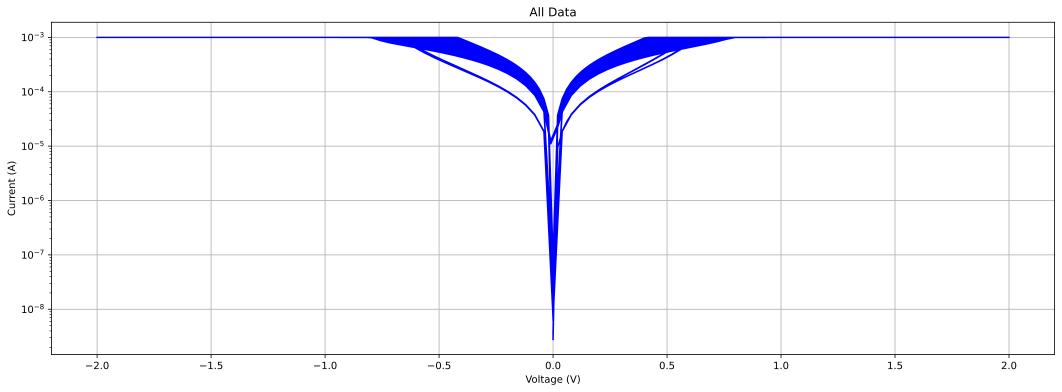

<Figure size 5400x1800 with 0 Axes>

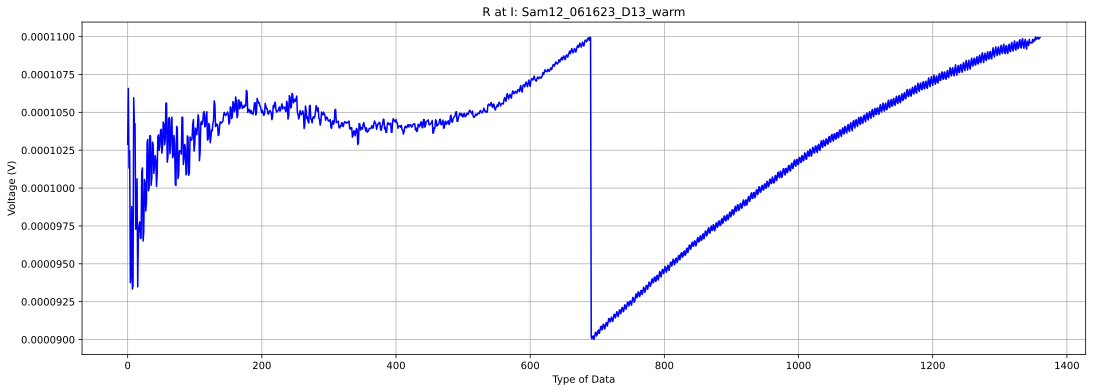

<Figure size 5400x1800 with 0 Axes>

In [730]:
# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");

# newest file: IVs_NbO2_Ti0_2nd_Sam2_053023_D13_cool

# theFiles = [
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_50ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_100msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_500msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_1000msbreak.txt")
# ]

theFiles = [
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam12_061623_D13_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam12_061623_D13_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam12_061523_D14_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam12_061523_D14_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam4_072123_2nd_D1_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam4_072123_2nd_D1_cool.txt"),
    
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam4_071923_2nd_D12_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam4_071923_2nd_D12_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_081523_D13_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_081423_D13_cool.txt"),

    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_070623_D18_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_070623_D18_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_070423_D12_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_070423_D12_cool.txt"),

    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_070123_D18_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_070123_D18_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_063023_D2_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_062823_D1_warm.txt"),

    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_cool_v2.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_080723_D13_cool.txt"),

    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072823_D11_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072823_D11_cool2.txt"),

    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072823_D11_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072723_D10_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072723_D10_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072523_D5_warm.txt"),

    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072523_D5_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_071723_D8_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_071723_D8_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_070823_D1_warm.txt"),

    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_070823_D1_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_062823_D12_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_062823_D12_cool.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam2_060123_D16_warm.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam2_053123_D16_cool.txt"),
]


all_data_to_graph = []

theFiles[0].graph_all_data()
data_to_graph = theFiles[0].return_resistances_at_current(1e-4)

the_graph = Graph(
            "R at I: " + theFiles[0].file_name[13:-4],   # title
            "Type of Data",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                                  # type of graph
            [data_to_graph],                          # data to graph
            [],                                     # points
        )

# for file in theFiles:
    # file.graph_voltage_vs_temp()
    # data_to_graph.append(file.return_voltage_vs_temp())
    # file.graph_voltage_vs_temp()




    # data_to_graph = file.return_voltage_vs_temp()

    # the_graph = Graph(
    #         "Box " + file.file_name[13:-4],   # title
    #         "Type of Data",                             # xlabel
    #         "Voltage (V)",                          # ylabel
    #         [],                                     # hlines
    #         "box",                                  # type of graph
    #         data_to_graph,                          # data to graph
    #         ["posThresh len: " + str(len(data_to_graph[0])), "negThresh len: " + str(len(data_to_graph[1])), "posHold len: " + str(len(data_to_graph[2])), "negHold len: " + str(len(data_to_graph[3]))],                                     # labels of box plot
    #     )
    




    # the_graph = Graph(
    #         "Box " + file.file_name[13:-4],   # title
    #         "Type of Data",                             # xlabel
    #         "Voltage (V)",                          # ylabel
    #         [],                                     # hlines
    #         "semilogy",                                  # type of graph
    #         file.return_voltage_vs_temp(),                          # data to graph
    #         ["posThresh", "negThresh", "posHold", "negHold"],                                     # labels of box plot
    #     )
    
    
    
#     all_data_to_graph.append(file.return_voltage_vs_temp())

# posThreshData = []
# negThreshData = []
# posHoldData = []
# negHoldData = []

# for data_set in all_data_to_graph:
#     posThreshData.append(data_set[0])
#     negThreshData.append(data_set[1])
#     posHoldData.append(data_set[2])
#     negHoldData.append(data_set[3])

# posThreshArray = np.array(posThreshData).flatten()
# negThreshArray = np.array(negThreshData).flatten()
# posHoldArray = np.array(posHoldData).flatten()
# negHoldArray = np.array(negHoldData).flatten()

# print("posThreshArray: ", posThreshArray)

# the_graph = Graph(
#             "Box All Data",   # title
#             "Voltage Type",                             # xlabel
#             "Voltage (V)",                          # ylabel
#             [],                                     # hlines
#             "box",                                  # type of graph
#             [posThreshArray, negThreshArray, posHoldArray, negHoldArray],                          # data to graph
#             ["posThresh", "negThresh", "posHold", "negHold"],                                     # labels of box plot
#         )
   



# the_graph = Graph(
#             "Break Times Box & Whisker",   # title
#             "Temp (K)",                             # xlabel
#             "Resistance (V)",                          # ylabel
#             [],                                     # hlines
#             "box",                                  # type of graph
#             [data_to_graph],                          # data to graph
#             [],                                     # points
#         )





# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt");


# theFile.graph_all_data()
# theFile.graph_IV_curves(2)
# theFile.graph_IV_curve(10)
# theFile.graph_voltage_vs_temp()





# theFile.graph_voltage_vs_resistance()
# theFile.graph_resistance_vs_temp()

# theFile.
# data_to_graph = [[], [], [], []]
# typeOfData = "posThresh"
# data_to_graph[0] = theFile.get_voltages_of_type(typeOfData)
# typeOfData = "posThresh"
# data_to_graph[1] = theFile.get_voltages_of_type(typeOfData)
# typeOfData = "posThresh"
# data_to_graph[2] = theFile.get_voltages_of_type(typeOfData)
# typeOfData = "posThresh"
# data_to_graph[3] = theFile.get_voltages_of_type(typeOfData)
# print(data_to_graph)
# the_graph = Graph(
#         "R vs Temp " + typeOfData,              # title
#         "Temp (K)",      # xlabel
#         "Resistance (Ω)",      # ylabel
#         [],                 # hlines
#         "semilogy",         # type of graph
#         [],      # data to graph
#         [data_to_graph],    # points
#     )
# data_to_graph = theFile.get_voltages_of_type("negThresh")





# theFile.graph_voltage_vs_temp_type("negThresh")
# theFile.graph_voltage_vs_temp_type("posHold")
# theFile.graph_voltage_vs_temp_type("negHold")
# # theFile.graph_voltage_vs_temp()
# # theFile.graph_resistance_vs_temp(0.2)
# # theFile.graph_resistance_vs_temp(0.3)

# for i in range(4, 6, 1):
#     index = i / 10
#     theFile.graph_resistance_vs_temp(index, "posThresh")
#     theFile.graph_resistance_vs_temp(index, "negThresh")
#     theFile.graph_resistance_vs_temp(index, "posHold")
#     theFile.graph_resistance_vs_temp(index, "negHold")

# theFile.graph_resistance_vs_temp(0.5)
# theFile.graph_resistance_vs_temp(0.6)
# theFile.graph_resistance_vs_temp(0.7)
# theFile.graph_resistance_vs_temp(0.8)
# theFile.graph_IV_curves_at_temp(84, 87)








# resistance as a function of temp as it cools. 4 graphs. 








# fig, ax = plt.subplots()

# # index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
# # points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])

# line, = ax.semilogy(0.0000000001, 0.0000001)
# # point = ax.plot(1, 1, marker="o", markersize=10, markeredgecolor='red', markerfacecolor='red')
# plt.xlim([-2, 2])
# plt.ylim([0.000000001, 0.003])
# plt.xlabel("Voltage (V)")
# plt.ylabel("Current (A)")
# plt.grid()


# def animate(i):

#     x = []
#     y = []
    
#     normal_i = i
#     i = i * (int)(len(theFile.IV_curves) / 100)

#     print("progress ", i, "/", len(theFile.IV_curves))

#     points_to_graph = []

#     # print("range: ", len(theFile.IV_curves[0]['V'] - 1))
#     for index in range(len(theFile.IV_curves[i]['V']) - 1):

#         four_curves_x = [
#             theFile.IV_curves[i + 0]['V'].tolist(),
#             theFile.IV_curves[i + 1]['V'].tolist(),
#             theFile.IV_curves[i + 2]['V'].tolist(),
#             theFile.IV_curves[i + 3]['V'].tolist(),
#             ]
        
#         four_curves_y = [
#             theFile.IV_curves[i + 0]['I'].tolist(),
#             theFile.IV_curves[i + 1]['I'].tolist(),
#             theFile.IV_curves[i + 2]['I'].tolist(),
#             theFile.IV_curves[i + 3]['I'].tolist(),
#             ]
        
#         fine_tune = 0
#         index_to_graph = [
#             theFile.IV_curves[i + 0]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 1]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 2]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 3]['max_ddI'] + fine_tune,
#             ]
        
#         points_to_graph = [
#             [theFile.IV_curves[i + 0]['V'][index_to_graph[0]], theFile.IV_curves[i + 0]['I'][index_to_graph[0]]],
#             [theFile.IV_curves[i + 1]['V'][index_to_graph[1]], theFile.IV_curves[i + 1]['I'][index_to_graph[1]]],
#             [theFile.IV_curves[i + 2]['V'][index_to_graph[2]], theFile.IV_curves[i + 2]['I'][index_to_graph[2]]],
#             [theFile.IV_curves[i + 3]['V'][index_to_graph[3]], theFile.IV_curves[i + 3]['I'][index_to_graph[3]]],
#         ]
        
#         # voltage = self.IV_curves[index + i]['V']
#         # current = self.IV_curves[index + i]['I']
#         # data_to_graph.append([voltage, current])

#         # fine_tune = 0
#         # type_of_data = self.IV_curves[index + i]['type_of_data']
#         # if type_of_data == "posThresh":
#         #     fine_tune = 1
#         # if type_of_data == "negThresh":
#         #     fine_tune = 1
#         # if type_of_data == "posHold":
#         #     fine_tune = -2
#         # if type_of_data == "negHold":
#         #     fine_tune = -2
        
#         # index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
#         # points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])
        
        
        
        
        
#         # print("V: ", four_curves_x)
#         # print("sum: ", sum(four_curves_x, []))
        
#         x.append(sum(four_curves_x, []))
#         y.append(sum(four_curves_y, []))

#         # print("type:", sum(x, []))



#         # 'time': self.time[start:stop],
#         # 'I': self.I[start:stop],
#         # 'dI': dI,
#         # 'ddI': ddI,
#         # 'V': self.V[start:stop],
#         # 'temps': self.temps[start:stop],
#         # 'temp': run_temp,
#         # 'temp_std': run_temp_std,
#         # 'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
#         # 'max_ddI': np.argmax(ddI),


#         # print("points_to_graph: ", points_to_graph)
#         # for point in points_to_graph:
#         #     plt.plot(point[0], point[1], marker="o", markersize=10, markeredgecolor='red', markerfacecolor='red')
    
#     title_time = "  Time =" + str(round(theFile.IV_curves[i]['time'][0])) + " s"
#     title_temp = "  Temp =" + str(round(theFile.IV_curves[i]['temp'])) + " K" + " Std: " + str(round(theFile.IV_curves[i]['temp_std'], 3))
#     title = "IV curve # " + str(i) + title_time + title_temp + " " + theFile.file_name
#     ax.set_title(title)
#     line.set_xdata(sum(x, []))  # update the data.
#     line.set_ydata(sum(y, []))  # update the data.
#     return line,


# # ani = animation.FuncAnimation(
# #     fig, animate, interval=50, blit=True, save_count=100)
# #                 # time between frames (ms)    number of frames
# # ani.save(theFile.file_name[:-4] + ".gif")

# # plt.show()




asdf

[array([ 0.04703812, -0.18090618,  0.0020403 , -0.06918346,  0.08695303,
        0.05146115,  0.07525902,  0.0157636 , -0.10347188, -0.0306024 ]), array([10.26169192,  9.97696096, 10.29026622, 10.07421185,  9.85502746,
        9.98036381,  9.68669453,  9.81234224, 10.31546583,  9.92231325]), array([ 99.93245621,  99.85035916,  99.89582224, 100.03592903,
        99.61990781, 100.42418502,  99.88494137, 100.26252864,
       100.51598972,  99.91266028])]


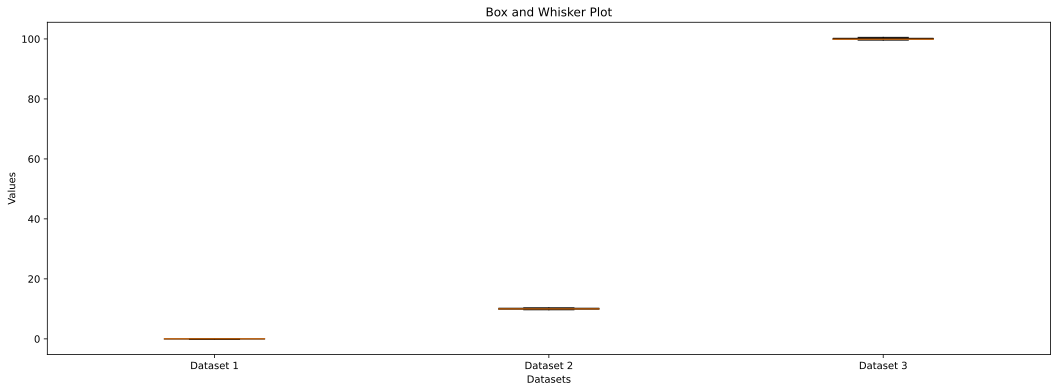

initial array [[1 2 3]
 [2 4 5]
 [1 2 3]]
New resulting array:  [1 2 3 2 4 5 1 2 3]


In [731]:
# four_curves_x = [
# theFile.IV_curves[5 + 0]['V'].tolist(),
# theFile.IV_curves[5 + 1]['V'].tolist(),
# theFile.IV_curves[5 + 2]['V'].tolist(),
# theFile.IV_curves[5 + 3]['V'].tolist(),
# ]
# print(theFile.file_name)
# print(type([1, 2, 3]))

# ini_list = four_curves_x
 
# # printing initial list
# print ("initial list ", str(ini_list))
 
# # converting 2d list into 1d
# flatten_list = sum(ini_list, [])
 
# # printing flatten_list
# print ("final_result", str(flatten_list))



# put everything on one Graph
# color code everything

# v vs r
# make gif for all files






# behaves as expected:
# IVs_NbO2_Ti0_2nd_Sam2_053023_D13_cool
# IVs_NbO2_Ti0_Sam3_051823_D22_opened
# IVs_NbO2_Ti0_Sam3_051823_D22 - very messy at the end
# IVs_NbO2_Ti0_Sam3_052423_D15_cool - very good
# IVs_NbO2_Ti10_Sam3_042023_D18_try2 - kinda messy at the end



# IVs_NbO2_Ti10_Sam3_042723_D18 - does nothing


data = [np.random.normal(0, 0.1, 10),
        np.random.normal(10, 0.2, 10),
        np.random.normal(100, 0.3, 10)]

print(data)


plt.boxplot(data, labels=['Dataset 1', 'Dataset 2', 'Dataset 3'])
plt.title('Box and Whisker Plot')
plt.xlabel('Datasets')
plt.ylabel('Values')
plt.show()


ini_array1 = np.array([[1, 2, 3], [2, 4, 5], [1, 2, 3]])
 
# printing initial arrays
print("initial array", str(ini_array1))
 
# Multiplying arrays
result = ini_array1.flatten()
 
# printing result
print("New resulting array: ", result)